### Comparison of two models, paired test

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import uniform, norm
import json

In [9]:
def extract_bounds(intervals):
        if isinstance(intervals, pd.Interval):
            return [intervals.left], [intervals.right]
        elif all(isinstance(interval, pd.Interval) for interval in intervals):
            lower_bounds = [interval.left for interval in intervals]
            upper_bounds = [interval.right for interval in intervals]
            return lower_bounds, upper_bounds
        else:
            raise TypeError("All elements must be pandas Interval objects or a single Interval object")

Select your two files containing the errors, with the same metric, of two models or two samples

In [10]:
errors_file_A = pd.read_csv("Errors/Errors_linear_MSE_150_150.csv")
errors_A = errors_file_A.values.flatten()
errors_file_B = pd.read_csv("Errors/Errors_quadratic_MSE_150_150.csv")
errors_B = errors_file_B.values.flatten()
errors = errors_A - errors_B
errors


array([ 1.45228482e-01, -7.50823719e-01,  5.17669136e-01,  5.33910858e-01,
        1.13493705e-01,  4.48231488e-02,  6.43165958e-01,  1.28860231e-01,
        2.48975041e-01, -7.11508387e-02,  2.55572978e-02,  2.54948708e-01,
       -1.21766637e-01,  9.01958739e-02, -3.92051139e-01,  9.92161378e-01,
       -1.66324248e-01,  6.04160541e-02, -5.20729623e-02,  1.29899960e-01,
        3.86090618e-01,  2.75148920e+00, -9.76909662e-02,  8.39091431e-01,
        2.24382559e-01,  1.45858053e-01,  6.56638944e-02,  1.97928074e-01,
       -1.32885809e-01,  3.96907821e-01,  4.98185562e-02, -4.23982894e-01,
        1.66319619e-01,  2.87563557e-01, -1.79173523e-01,  6.87183995e-02,
       -5.71031663e-02,  1.13491348e-01,  3.00877223e-01,  4.59161896e-01,
        3.14067902e-01, -1.02170028e-02, -1.72361731e-02, -2.62465534e-02,
        2.58698537e-01, -4.95661443e-01,  1.54568673e-02,  5.53128054e-01,
        4.53582297e-02, -1.85510218e-02, -2.08461975e-01,  2.17848951e-02,
       -3.09616177e-01, -

In [11]:
def descriptive_statistics():

    alpha = 0.05

    empirical_mean = np.mean(errors)
    empirical_std_deviation = np.std(errors, ddof=1)
    q1 = np.percentile(errors, 25)
    med = np.percentile(errors, 50)
    q3 = np.percentile(errors, 75)

    print("The empirical mean is :", empirical_mean)
    print("The empirical standard deviation is :", empirical_std_deviation)
    print("The empirical first quartile is :", q1)
    print("The empirical mediane is :", med)
    print("The empirical third quartile is :", q3)

    std_error_param = empirical_std_deviation/(len(errors)**0.5)

    B = 250
    bootstrap_indices = np.random.choice(len(errors), size=(B, len(errors)), replace=True)
    bootstrap = []

    for indices in bootstrap_indices:
      boot_mean = np.mean(errors[indices])
      bootstrap.append(boot_mean)

    bootstrapped_mean = np.mean(bootstrap)
    bootstrapped_std_error = np.std(bootstrap)

    print("The bootstrapped empirical mean is :", bootstrapped_mean)
    print("The empirical standard error is :", std_error_param)
    print("The bootstrapped empirical standard error is :", bootstrapped_std_error)

    t_critical = 1.96
    lower = empirical_mean - t_critical * std_error_param
    upper = empirical_mean + t_critical * std_error_param

    conf_interval = pd.Interval(left=lower, right=upper, closed='both')

    print("A 95'%' confidence interval for the mean is :", conf_interval)

    lower_boot = np.percentile(bootstrap , 100 * (alpha/2))
    upper_boot = np.percentile(bootstrap, 100 * (1 - alpha / 2))

    conf_interval_perc_boot = pd.Interval(left=lower_boot, right=upper_boot, closed='both')

    print("A 95'%' percentile boostrap confidence interval for the mean is :", conf_interval_perc_boot)

    conf_interval_basic_boot = pd.Interval(left=2*empirical_mean-upper_boot, right=2*empirical_mean-lower_boot, closed='both')

    print("A 95'%' basic boostrap confidence interval for the mean is :", conf_interval_basic_boot)

    # Acceleration
    jackknife_samples = np.array([np.mean(np.delete(errors, i)) for i in range(len(errors))])
    jackknife_mean = np.mean(jackknife_samples)
    a = np.sum((jackknife_mean - jackknife_samples) ** 3) / (6 * np.sum((jackknife_mean - jackknife_samples) ** 2) ** 1.5)

    # Bias correction
    z0 = stats.norm.ppf(np.mean(bootstrap < empirical_mean))

    z_alpha = norm.ppf(alpha / 2)
    z_1_alpha = norm.ppf(1 - alpha / 2)
    
    lower_percentile = norm.cdf(z0 + (z0 + z_alpha) / (1 - a * (z0 + z_alpha))) * 100
    upper_percentile = norm.cdf(z0 + (z0 + z_1_alpha) / (1 - a * (z0 + z_1_alpha))) * 100

    conf_interval_bca_boot = np.percentile(bootstrap, [lower_percentile, upper_percentile])

    print("A 95'%' accelerated boostrap confidence interval for the mean is :", conf_interval_bca_boot)

    y1, y2 = extract_bounds(conf_interval)
    y3, y4 = extract_bounds(conf_interval_basic_boot)
    y5, y6 = extract_bounds(conf_interval_perc_boot)
    y7, y8 = conf_interval_bca_boot[0], conf_interval_bca_boot[1]

    plt.figure(figsize=(10, 6))
    plt.axhline(y1, label='lower bound student mean interval ', marker='o', color="lightblue")
    plt.axhline(y2, label='upper bound student mean interval', marker='o', color="darkblue")
    plt.axhline(y3, label='lower bound Basic boot', marker='o', color="brown")
    plt.axhline(y4, label='upper bound Basic boot', marker='o', color="darkred")
    plt.axhline(y5, label='lower bound Perc boot', marker='o', color="lightgreen")
    plt.axhline(y6, label='upper bound Perc boot', marker='o', color="darkgreen")
    plt.axhline(y7, label='lower bound BCA boot', marker='o', color="yellow")
    plt.axhline(y8, label='upper bound BCA boot', marker='o', color="orange")

    plt.xlabel('')
    plt.title('Different confidence intervals of mean of the difference')
    plt.legend()
    plt.grid(True)
    plt.show()

    supposed_mean = 0 # to change (here, equality of performance)

    test_stat = empirical_mean-supposed_mean/std_error_param # Bilateral test : Model A has the same performance as model B.
    student = stats.t.ppf(1-alpha/2, df=len(errors)-1)
    p_value = 1 - stats.t.cdf(test_stat, df=len(errors)-1)
    puissance = 1 - stats.norm.cdf(student - test_stat, 0, 1)

    print("The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :")
    print("The p-value of the bilateral test is :", p_value)
    print("The power of the bilateral test is :", puissance)

    # With bootstrapped values

    test_stat_boot = bootstrapped_mean-supposed_mean/bootstrapped_std_error 
    p_value_boot = 1 - stats.t.cdf(test_stat_boot, df=len(errors)-1)
    puissance_boot = 1 - stats.norm.cdf(student - test_stat, 0, 1)

    print("The bootstrapped p-value of the bilateral test is :", p_value_boot)
    print("The bootstrapped power of the bilateral test is :", puissance_boot)


    data = {
    "Empirical mean": empirical_mean,
    "Empirical standard deviation": empirical_std_deviation,
    "Empirical first quartile": q1,
    "Empirical median": med,
    "Empirical third quartile": q3,
    "Bootstrapped empirical mean": bootstrapped_mean,
    "Empirical standard error": bootstrapped_std_error,
    "Bootstrapped empirical standard error": std_error_param,
    "95% confidence interval for the mean": str(conf_interval),
    "95% percentile bootstrap confidence interval for the mean": str(conf_interval_perc_boot),
    "95% basic bootstrap confidence interval for the mean": str(conf_interval_basic_boot),
    "95% accelerated bootstrap confidence interval for the mean": str(conf_interval_bca_boot)
}

    additionnal_info = "Logistic_vs_DecisionTree_gamma90"
    json_file_path = f"Summary/statistics_comparison_{additionnal_info}_summary.json" # a modifier
    with open(json_file_path, 'w') as json_file:
       json.dump(data, json_file, indent=4)

    print(f"Les données ont été sauvegardées dans le fichier {json_file_path}")


The empirical mean is : 0.10860772723772735
The empirical standard deviation is : 0.48856444113031655
The empirical first quartile is : -0.11304479167949694
The empirical mediane is : 0.0393603772421682
The empirical third quartile is : 0.3107702322993331
The bootstrapped empirical mean is : 0.1093457568263957
The empirical standard error is : 0.039891119574576875
The bootstrapped empirical standard error is : 0.038076512012062025
A 95'%' confidence interval for the mean is : [0.030421132871556678, 0.18679432160389803]
A 95'%' percentile boostrap confidence interval for the mean is : [0.04149933455624753, 0.18167917311901155]
A 95'%' basic boostrap confidence interval for the mean is : [0.035536281356443156, 0.17571611991920716]
A 95'%' accelerated boostrap confidence interval for the mean is : [0.0450968 0.1871258]


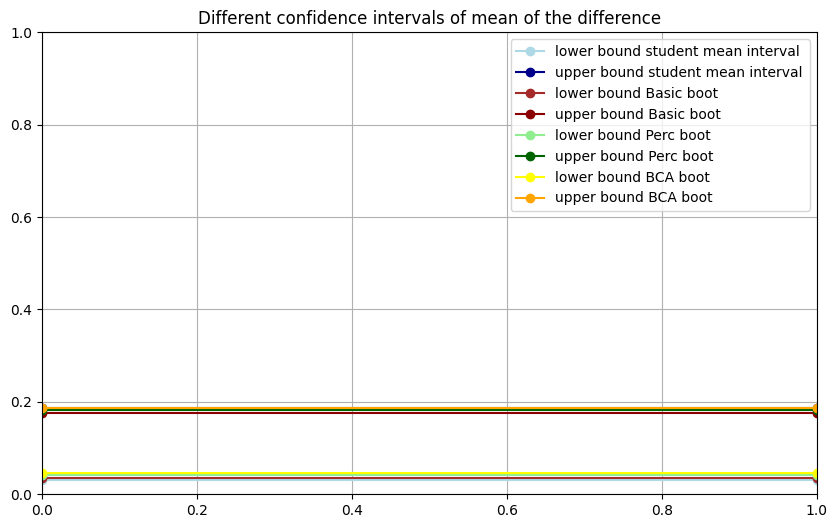

The following bilateral test checks if your hypothesis on the equal performance of two models is reasonable :
The p-value of the bilateral test is : 0.45682987675916786
The power of the bilateral test is : 0.03092249462420038
The bootstrapped p-value of the bilateral test is : 0.456537690947194
The bootstrapped power of the bilateral test is : 0.03092249462420038
Les données ont été sauvegardées dans le fichier Summary/statistics_comparison_Logistic_vs_DecisionTree_gamma90_summary.json


In [12]:
descriptive_statistics()

In [13]:
import pymc3 as pm

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.


Our assumptions are the following :

We know that the errors follow a chi-2 with 1 ddof. (likelihood)
So we make the prior that our real means follow an inversed chi-2.




The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu quadratic, mu linear]
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The versi

/Users/antoine/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/antoine/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/antoine/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


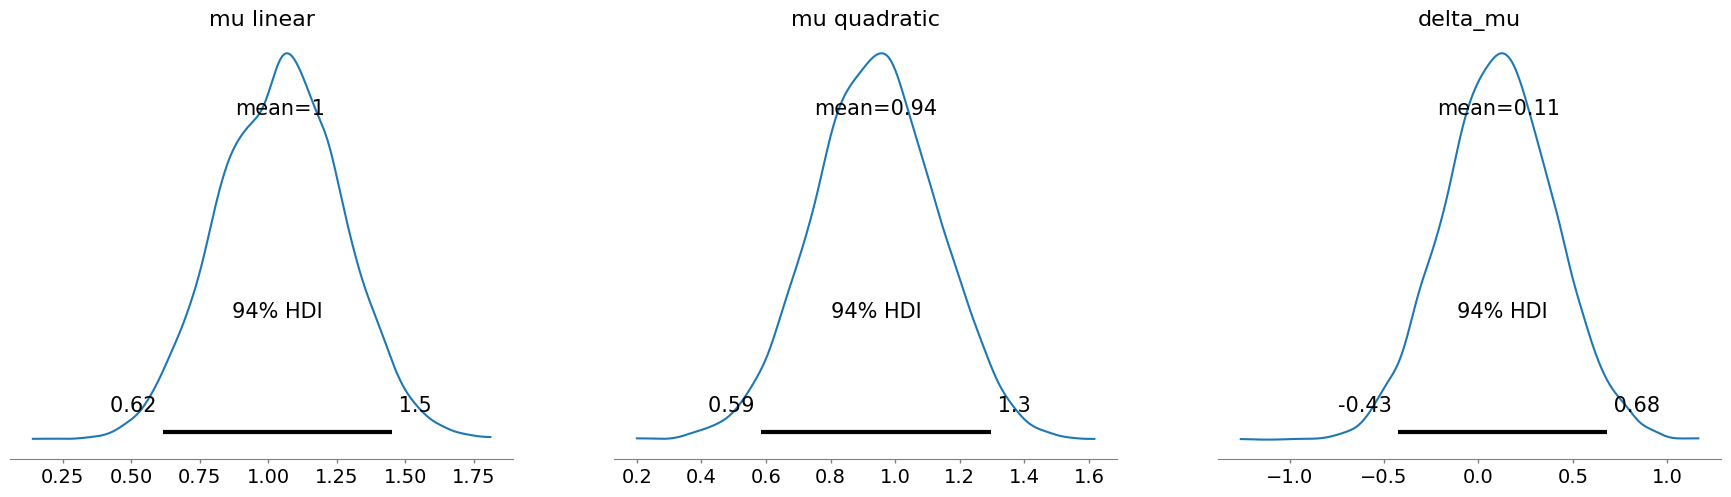

Probabilité que la différence des moyennes soit supérieure à 0 : 0.64


In [14]:
sigma_A = np.std(errors_A)
sigma_B = np.std(errors_B)

# Modèle bayésien avec PyMC3
with pm.Model() as model:
    # Priors pour les variances, utilisant la distribution Inverse Gamma
    mu1 = pm.Normal('mu linear', mu=0, sigma=100)
    mu2 = pm.Normal('mu quadratic', mu=0, sigma=100)
    
    # Likelihood
    y1 = pm.Normal('Likelihood linear', mu=mu1, sigma=sigma_A**2, observed=errors_A)
    y2 = pm.Normal('Likelihood quadratic', mu=mu2,sigma=sigma_B**2 ,observed=errors_B)
    
    # Différence des moyennes
    delta_mu = pm.Deterministic('delta_mu', mu1 - mu2)
    
    # Inference
    trace = pm.sample(2000, return_inferencedata=False)

# Résultats
pm.plot_posterior(trace, var_names=['mu linear', 'mu quadratic', 'delta_mu'])
plt.show()

# Probabilité que la différence des moyennes soit supérieure à 0
delta_mu_samples = trace['delta_mu']
prob_delta_mu_gt_zero = np.mean(delta_mu_samples > 0)
print(f"Probabilité que la différence des moyennes soit supérieure à 0 : {prob_delta_mu_gt_zero:.2f}")